## For New Data

In [2]:
## IMPORT MANUALLY LABELED DATASET (image_labels.csv)

import pandas as pd
df=pd.read_csv("./image_labels.csv")

In [17]:
## Upload one file of the bounding box labeled outputs from Label Studio for EUIP address and one for NYIP address
eu_objects=pd.read_csv("./label_studio_euip.csv")
ny_objects=pd.read_csv("./label_studio_nyip.csv")

In [ ]:
ny_objects['EUIP']=False
eu_objects['EUIP']=True
df_new=pd.concat([ny_objects,eu_objects],axis=0)
df_new

In [19]:
## We record the size of each banner button (size based on % of pixels)
df_new['x']=0
df_new['accept']=0
df_new['reject']=0
df_new['manage']=0
df_new['banner']=0
import json
for i in range(len(df_new)):
    json_string=df_new['label'][i]
    data = json.loads(json_string)
    for j in range(len(data)):
        t=data[j]['rectanglelabels'][0]
        area=data[j]['width']*data[j]['height']
        df_new.at[i,t]=area
        
#label studio image label into domain URL.
def shorten_url(row):
    url=row['image'][24:-4]
    return url 
    
df_new['shortened_url'] = df_new.apply(shorten_url, axis=1)
#eu_objects['shortened_url'] = eu_objects.apply(shorten_url, axis=1)

C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1686372056.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '107.06875184864482' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ny_objects.at[i,t]=area
C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1686372056.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '91.59963056453248' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ny_objects.at[i,t]=area
C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1686372056.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '73.81715126361173' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ny_objects.at[i,t]=area
C:\Users\riley\AppData\Local\Temp\ipykernel_3

In [21]:
## Copy over the manual label of image type into the new DF 
for i in range(len(df_new)):
    url=df_new.shortened_url[i]
    if df_new.EUIP[i]==True:
        label=df[df.Domain==url]['Label_finalEU'].item()
        df_new.at[i,'Final_label']=label
    else:
        label=df[df.Domain==url]['Label_finalNY'].item()
        df_new.at[i,'Final_label']=label
    
#ny_objects['Final_label']=''   
#for i in range(len(ny_objects)):
#    url=ny_objects.shortened_url[i]
#    label=df[df.Domain==url]['Label_finalNY'].item()
#    ny_objects.at[i,'Final_label']=label

In [24]:
## Now we aggregate pioxel-level salience values of each button to get the avg and max salience of each button
## MUST include path to outputs from DeepRare images. 
from PIL import Image
import numpy as np
df_new['x_salience_avg']=0
df_new['accept_salience_avg']=0
df_new['reject_salience_avg']=0
df_new['manage_salience_avg']=0
df_new['banner_salience_avg']=0
df_new['x_salience_max']=0
df_new['accept_salience_max']=0
df_new['reject_salience_max']=0
df_new['manage_salience_max']=0
df_new['banner_salience_max']=0
for i in range(len(df_new)):
    json_string=df_new['label'][i]
    data = json.loads(json_string)
    domain=df_new.shortened_url[i]
    if df_new.EUIP[i]==True:
        image = Image.open(f".SOD_model_outputs_EU/{domain}.jpg")
    else:
        image = Image.open(f".SOD_model_outputs_NY/{domain}.jpg")
    #image = Image.open(f"C:/Users/riley/deeprare2019/SOD_outputs_EU/{domain}.jpg")
    image_array = np.array(image)
    for j in data:
        t=j['rectanglelabels'][0]
        x=j['x']
        y=j['y']
        height=j['height']
        width=j['width']
        original_height=j['original_height']
        original_width=j['original_width']
        avg_salience=(image_array[int(y/100*original_height):int((y+height)/100*original_height),int(x/100*original_width):int((x+width)/100*original_width)].mean())
        df_new.at[i,f'{t}_salience_avg']=avg_salience
        max_salience=(image_array[int(y/100*original_height):int((y+height)/100*original_height),int(x/100*original_width):int((x+width)/100*original_width)].max())
        df_new.at[i,f'{t}_salience_max']=max_salience
    image.close()

C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1520244230.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '81.90894439967768' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eu_objects.at[i,f'{t}_salience_avg']=avg_salience
C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1520244230.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90.85467028003613' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eu_objects.at[i,f'{t}_salience_avg']=avg_salience
C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1520244230.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '54.65451290748069' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eu_objects.at[i,f'

In [26]:
#Necessary if you want to capture avg and max salience of the full website landing page (not necessary for key analyses)
df_new['image_salience_avg']=0
df_new['image_salience_max']=0
for i in range(len(eu_objects)):
    domain=df_new.shortened_url[i]
    if df_new.EUIP[i]==True:
        image = Image.open(f".SOD_model_outputs_EU/{domain}.jpg")
    else:
        image = Image.open(f".SOD_model_outputs_NY/{domain}.jpg")
    #image = Image.open(f"C:/Users/riley/deeprare2019/SOD_outputs_EU/{domain}.jpg")
    image_array = np.array(image)
    avg=image_array.mean()
    m=image_array.max()
    df_new.at[i,'image_salience_avg']=avg
    df_new.at[i,'image_salience_max']=m

C:\Users\riley\AppData\Local\Temp\ipykernel_32860\1719500407.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56.77061068869943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eu_objects.at[i,'image_salience_avg']=avg


In [30]:
from collections import Counter
Counter(df_new.Final_label)

Counter({'full': 755,
         'manage': 346,
         'full xa': 142,
         'full-m': 97,
         'full choices': 70,
         'x': 69,
         'manage xa': 59,
         'choices': 43,
         'full-m xa': 24,
         'preselected': 19,
         'ambiguous': 16,
         'notice': 15,
         'full choices xa': 12,
         'SETTINGS ONLY xa': 6,
         'choices xa': 6,
         '2 banners': 1})

In [31]:
## Remove any banners that are non-compliant (e.g., preselected options) or do not have multiple buttons (e.g., notice).
df_new=df_new[(df_new.Final_label!='2 banners')&(df_new.Final_label!='SETTINGS ONLY xa')&(df_new.Final_label!='notice')&(df_new.Final_label!='preselected')&(df_new.Final_label!='ambiguous')]
df_new

,annotation_id,annotator,created_at,id,image,label,lead_time,updated_at,x,accept,...,manage_salience_avg,banner_salience_avg,x_salience_max,accept_salience_max,reject_salience_max,manage_salience_max,banner_salience_max,image_salience_avg,image_salience_max,EUIP
0,1096,1,2024-12-30T14:12:59.406387Z,1,/data/upload/8/84b7a409-7sun.eu.png,"[{""x"":27.47708509903632,""y"":43.292682926829265...",39.504,2024-12-30T14:12:59.406387Z,0.000000,73.817151,...,119.497360,102.080736,0,196,185,170,255,68.872834,255,False
1,1097,1,2024-12-30T14:13:32.479612Z,2,/data/upload/8/fff7c5e1-20minutes.fr.png,"[{""x"":53.57456759895784,""y"":47.15447154471545,...",30.232,2024-12-30T14:13:32.479612Z,0.000000,143.007586,...,156.890282,106.793384,0,255,218,210,255,76.742515,255,False
2,1098,1,2024-12-30T14:14:13.806121Z,3,/data/upload/8/ce87ce71-24.hu.png,"[{""x"":74.38357346893932,""y"":89.43089430894308,...",39.357,2024-12-30T14:14:13.806121Z,0.000000,176.656430,...,108.761281,92.231633,0,245,0,255,255,77.782829,255,False
4,1100,1,2024-12-30T14:16:56.386540Z,5,/data/upload/8/238cee6c-abrmesstechnik.de.png,"[{""x"":24.32019289995944,""y"":82.10116731517509,...",55.581,2024-12-30T14:16:56.386540Z,0.000000,357.157471,...,73.426052,90.648585,0,222,168,254,255,63.277013,255,False
5,1101,1,2024-12-30T14:17:38.731273Z,6,/data/upload/8/c3e364fa-acosol.es.png,"[{""x"":82.31449904601656,""y"":92.60700389105058,...",113.870,2024-12-31T14:37:01.979380Z,0.000000,54.102442,...,63.885648,48.086657,0,66,80,129,207,52.675682,255,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,2778,1,2024-12-31T23:19:46.462138Z,1677,/data/upload/9/6844015f-zoom.us.png,"[{""x"":74.86157253599114,""y"":11.159615842527186...",20.380,2024-12-31T23:19:46.462138Z,23.524282,112.461245,...,65.794650,71.898904,158,171,170,127,215,72.773920,255,True
1026,2779,1,2024-12-31T23:20:05.883228Z,1678,/data/upload/9/ddb4f06c-zoopla.co.uk.png,"[{""x"":50.0553716293362,""y"":76.35528628538279,""...",17.959,2024-12-31T23:20:05.883228Z,0.000000,211.610131,...,91.009144,97.771940,0,255,227,158,255,66.146444,255,True
1027,2780,1,2024-12-31T23:21:30.344314Z,1679,/data/upload/9/b978484c-zoznam.sk.png,"[{""x"":61.240307502588784,""y"":84.87277737893785...",83.016,2024-12-31T23:21:30.344314Z,0.000000,131.068328,...,44.579447,65.136321,0,239,60,77,255,49.301033,255,True
1028,2781,1,2024-12-31T23:21:51.968252Z,1680,/data/upload/9/8664f200-zwoenitz.de.png,"[{""x"":59.468438538205994,""y"":61.47577850093923...",18.126,2024-12-31T23:21:51.968252Z,0.000000,106.151967,...,114.681107,114.146895,0,222,208,174,255,83.570331,255,True


In [33]:
## save this new df as the "labeled_banners.csv"
df_new.to_csv('./labeled_banners.csv')

## Analysis (For Replicating Paper Results)

In [2]:
import pandas as pd
## Load the labeled banners file to replicate results
##Or use your created one from previous section if using new data
df_new=pd.read_csv('./labeled_banners.csv')

In [4]:
len(df_new[df_new.EUIP==True]),len(df_new[df_new.EUIP==False])

(1006, 617)

In [9]:
df_new=df_new[(df_new.Final_label=='full')|(df_new.Final_label=='full choices')|(df_new.Final_label=='x')]

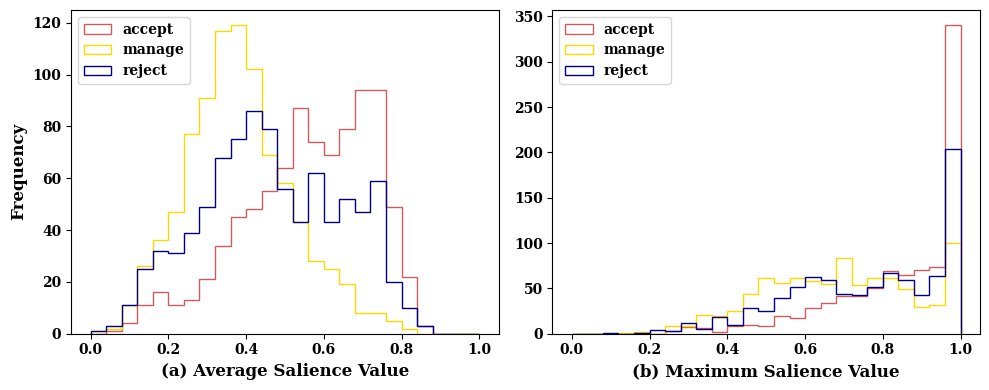

In [10]:
## Creates Fig 9 in Appendix to show comparison of max and avg aggregation strategy. 
#We decide to normalize and add together for further analysis.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.size'] = 10        
plt.rcParams['font.weight'] = 'semibold'

value_range = (0, 1) 
bins = 25 


filtered_data = {
    col: df_new[col][df_new[col] != 0]/255 for col in ['accept_salience_avg', 'manage_salience_avg', 'reject_salience_avg']
}


colors = ['indianred', 'gold', 'navy']


plt.style.use('default') 
plt.figure(figsize=(10, 4), facecolor='white') 
plt.subplot(1, 2, 1) 
for col, color in zip(filtered_data.keys(), colors):
    plt.hist(
        filtered_data[col],
        bins=bins,
        range=value_range,
        histtype='step',
        color=color,
        label=col[:-13]
    )
plt.xlabel('(a) Average Salience Value', fontsize=12, fontdict={'family': 'serif', 'weight': 'semibold'})
plt.ylabel('Frequency', fontsize=12, fontdict={'family': 'serif', 'weight': 'semibold'})
plt.xticks(fontsize=10, fontfamily='serif', weight='semibold')
plt.yticks(fontsize=10, fontfamily='serif', weight='semibold')
plt.legend(title_fontsize=12, loc='upper left', fontsize=10, prop={'family': 'serif', 'weight': 'semibold'})

filtered_data = {
    col: df_new[col][df_new[col] != 0]/255 for col in ['accept_salience_max', 'manage_salience_max', 'reject_salience_max']
}
plt.subplot(1, 2, 2) 
for col, color in zip(filtered_data.keys(), colors):
    plt.hist(
        filtered_data[col],
        bins=bins,
        range=value_range,
        histtype='step', 
        color=color,
        label=col[:-13]
    )
plt.xlabel('(b) Maximum Salience Value', fontsize=12, fontdict={'family': 'serif', 'weight': 'semibold'})
plt.xticks(fontsize=10, fontfamily='serif', weight='semibold')
plt.yticks(fontsize=10, fontfamily='serif', weight='semibold')
plt.legend(title_fontsize=12, loc='upper left', fontsize=10, prop={'family': 'serif', 'weight': 'semibold'})


plt.tight_layout() 
plt.savefig('avg_max_sal_revision.pdf', format='pdf', dpi=1200)
plt.show()